In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow as tf
from config import Config
import utils
import model as modellib
import visualize
from tqdm import tqdm
from model import log
from utils import resize_image, resize_mask

from keras.utils import Progbar
from skimage.io import imread, imshow, imread_collection, concatenate_images, imsave
from visualize import display_images
from keras import backend as K
from scipy import ndimage
import kaggle_util
from keras.applications.resnet50 import preprocess_input
from model import *

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

TRAIN_PATH = '/home/kownse/code2/kaggle/ship/input/train_v2/'
VALID_PATH = '/home/kownse/code2/kaggle/ship/input/train_v2/'

train_ids = next(os.walk(TRAIN_PATH))[1]
#test_ids = next(os.walk(TEST_PATH))[1]
total_size = len(train_ids)

IMG_SIZE = 768

Using TensorFlow backend.


In [2]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction
    
class ShipConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "ship"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes
    BACKBONE = 'resnet50'
    
    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 768
    IMAGE_MAX_DIM = 768
    IMAGE_PADDING = True
    LEARNING_RATE = 0.002

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 128
    DETECTION_MAX_INSTANCES = 32
    MAX_GT_INSTANCES = 32
    RPN_TRAIN_ANCHORS_PER_IMAGE = 32
    #BACKBONE = "resnet50"

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 1000

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 150
    ARGUMENT = 1
    LEARNING_RATE = 0.001

class CoCoShipConfig(ShipConfig):
    NAME = "coco_ship_"
    IMAGES_PER_GPU = 2
    STEPS_PER_EPOCH = 10000
    VALIDATION_STEPS = 1000
    TRAIN_FROM_COCO = 1

    IMAGE_CHANEL = 3
    
class InferenceConfig(CoCoShipConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
class ShipConfig_101(CoCoShipConfig):
    NAME = "res101"
    BACKBONE = 'resnet101'
    TRAIN_FROM_COCO = 0
    
class InferenceConfig_101(ShipConfig_101):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    
train_config = CoCoShipConfig
test_config = InferenceConfig_101

class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    scale_ = 1.0
    padding_ = None
    segment = pd.read_csv('/home/kownse/code2/kaggle/ship/input/train_ship_segmentations_v2.csv.zip')

    exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg']
    
    def load_imgs(self, basepath):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "ship")
        
        folds = pd.read_csv('../input/folds.csv')
        if self.fold >= 0:
            if self.valid == 0:
                folds = folds.loc[folds.fold != self.fold]
            else:
                folds = folds.loc[folds.fold == self.fold]
        if self.valid >= 0:
            folds = folds.loc[folds.holdout == self.valid]
            
        print(basepath, 'total imgs', len(folds))
        prog = tqdm(total = len(folds))
        for idx, row in folds.iterrows():
            id_ = row.ImageId
            if id_ in self.exclude_list:
                continue
                
            if row.has_ship == 0:
                continue
            
            img_path = basepath + id_
            if not os.path.isfile(img_path):
                continue

            shapes = []
            self.add_image("shapes", image_id=id_, path = img_path,
                           width=None, height=None, shapes=shapes)
            prog.update(1)
            
            if idx > 100:
                break

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        path = info['path']
        img = imread(path)
        if img.shape[0] == 0:
            img = np.zeros((IMG_SIZE,IMG_SIZE,3))
        img = preprocess_input(img)
        img = img.astype(np.uint8)
        
        info['width'] = img.shape[0]
        info['height'] = img.shape[1]
        
        return img

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def masks_as_image(self, rle, IMG_WIDTH, IMG_HEIGHT):
        # Take the individual ship masks and create a single mask array for all ships
        cnt = len(rle)
        all_masks = np.zeros((IMG_WIDTH, IMG_HEIGHT, cnt), dtype = np.int8)
        for idx, mask in enumerate(rle):
            if isinstance(mask, str):
                all_masks[:,:,idx] += rle_decode(mask)
        return all_masks

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        #print(info['id'], np.in1d(info['id'], self.segment['EncodedPixels']))
        rle = self.segment.loc[self.segment.ImageId==info['id'], 'EncodedPixels']
        #print('rle shape', rle.shape, rle)
        masks = self.masks_as_image(rle, info['width'], info['height'])
        class_ids = np.array([self.class_names.index('ship') for i in range(len(rle))])
        return masks, class_ids.astype(np.int32)

In [3]:
dataset = ShapesDataset(-1, 0)
dataset.load_imgs(TRAIN_PATH)
dataset.prepare()

/home/kownse/code2/kaggle/ship/input/all/ total imgs 101982
  0%|          | 24/101982 [00:00<01:29, 1136.55it/s]


argment True


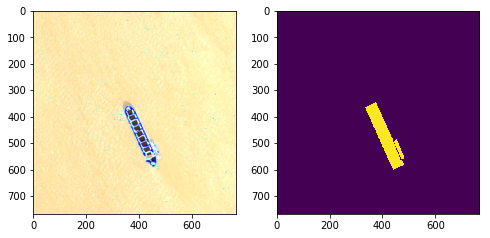

In [24]:
def show_img_maskcombine(img, mask):
    combine_mask = np.zeros((768,768), dtype=np.int16)
    for i in range(mask.shape[2]):
        combine_mask += mask[...,i]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 8))
    ax1.imshow(img)
    ax2.imshow(combine_mask)
    
    return combine_mask

def showgt(idx):
    image, image_meta, class_ids, bbox, mask =\
    load_image_gt(dataset, train_config, idx, True, False, -1)
    combine_mask = show_img_maskcombine(image, mask)
    
    return image, mask, combine_mask

image, mask, combine_mask = showgt(20)

In [27]:
folds = pd.read_csv('../input/folds.csv')

In [28]:
folds.head()

,ImageId,ships,has_ship,fold,holdout
0,00003e153.jpg,0,0,2,0
1,000155de5.jpg,1,1,1,1
2,00021ddc3.jpg,9,1,1,0
3,0002756f7.jpg,2,1,0,0
4,0002d0f32.jpg,0,0,1,0
